# <u> Memory-based Collaborative Filtering</u>

This notebook explores **memory-based collaborative filtering** as a first baseline for building a movie recommendation system. The approach relies solely on the raw user–item rating matrix, without the need for training or any machine learning framework.

The general idea is to build recommendations based on similarities, which can be computed in two main ways:

- **User–User Collaborative Filtering**: recommends movies liked by users who have similar preferences and rating behavior to us.
- **Item–Item Collaborative Filtering**: recommends new movies that are similar to the ones we have already seen and liked.

<br>

To define similarities between users or items, we commonly use two metrics:

- **Cosine Similarity**: a fast and popular measure that computes the angle between two vectors (single users or items). The formula is:

<br>

$$
\text{sim}_{\text{cosine}}(x, y) = \frac{x \cdot y}{\|x\| \|y\|}
$$

<br>

- **Pearson Correlation**: more computationally demanding, but it measures the linear relationship between co-rated items, correcting for each user’s individual rating bias. The formula is:

<br>

$$
\text{sim}_{\text{pearson}}(x, y) = \frac{\sum_{i}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum(x_i - \bar{x})^2} \sqrt{\sum(y_i - \bar{y})^2}}
$$

<br>

Due to its ability to correct for individual rating biases, Pearson correlation is particularly effective in user–user collaborative filtering, where users may differ significantly in how they rate items. However, in item–item collaborative filtering, this adjustment is not appropriate, as centering on item means does not address user-level biases. Instead, cosine similarity and its adjusted form,are used to account for user rating behavior when comparing items.


## <u>0. Setting:</u>

### <u>0.1 Import libraries and dataframe</u>

In [2]:
# Import necessary libraries
import pandas as pd, numpy as np, os, sys
from surprise import Dataset, Reader, KNNWithMeans, accuracy
import time
import matplotlib.pyplot as plt

# Remove Userwarning
import warnings
warnings.filterwarnings("ignore")


# Set the working directory
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)


In [3]:
# Import cleand dataframe
rating_df = pd.read_csv('../data/processed/ratings.csv')
rating_df.head(3)

,userId,movieId,rating,timestamp
0,27,11,4.0,2005-03-31 04:36:25
1,27,29,3.0,2005-03-31 04:39:31
2,27,47,4.5,2005-03-31 04:34:52


In [4]:
print(f"Number of unique userId: {rating_df['userId'].nunique()}")
print(f"Number of unique movieId: {rating_df['movieId'].nunique()}")
print(f"Number of reviews: ~ {len(rating_df)/1000000:.1f} M")

Number of unique userId: 5976
Number of unique movieId: 6568
Number of reviews: ~ 0.9 M


### <u>0.2 Model Evaluation</u>

To evaluate model performance and allow fair comparison across approaches, we use a **train–validation–test split** based on time. For each user, the **earliest 70% of their ratings** are used for training, the **next 10% for validation**, and the **most recent 20% for testing**. This chronological setup reflects a realistic recommendation scenario, where predictions are made for unseen items based on past user behavior, while the validation set is used for hyperparameter tuning. This percentage-based approach, rather than a fixed number of ratings, ensures that the train, validation, and test sets are proportional to each user’s activity, allowing fair comparison across users with different numbers of ratings.

Model performance is primarily assessed using the **Root Mean Squared Error (RMSE)** between predicted and actual ratings on held-out items in both the validation and test sets. RMSE is expressed in its square root form to remain on the same scale as the original ratings, making the results easier to interpret. To better understand model behavior under different data availability conditions, the test set is further split into **warm-start** and **cold-start** subsets. A test rating is considered cold-start if the corresponding movie appears **fewer than 10 times in the training set**; otherwise, it is treated as warm-start. This distinction allows us to separately evaluate performance on well-represented items and on sparsely observed movies, which typically pose a greater challenge for recommendation models.


In [40]:

# Sort by user and timestamp to preserve chronological order
sorted_df = rating_df.sort_values(by=['userId','timestamp'], ascending=[True, True])

train_list, val_list, test_list = [], [], []

# Group by user and split each user's data to train/val/test
for user, group in sorted_df.groupby('userId'):
    n = len(group)
    train_end = int(n * 0.7)
    val_end = int(n * 0.8)
    
    # Split per user
    train_list.append(group.iloc[:train_end])
    val_list.append(group.iloc[train_end:val_end])
    test_list.append(group.iloc[val_end:])
    
# Concatenate per-user splits into global datasets
train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

# Remove timestamp for Surprise
train_df = train_df.drop(columns=['timestamp'])
val_df = val_df.drop(columns=['timestamp'])
test_df = test_df.drop(columns=['timestamp'])

# Count number of ratings per movie in the training set
movie_counts = train_df['movieId'].value_counts()

# Identify cold movies (<10 ratings in training)
cold_movies = movie_counts[movie_counts < 10].index

# Split test set into warm and cold
cold_test_df = test_df[test_df['movieId'].isin(cold_movies)].reset_index(drop=True)
warm_test_df = test_df[~test_df['movieId'].isin(cold_movies)].reset_index(drop=True)

# Save all datasets
train_df.to_csv('../data/processed/train_df.csv', index=False)
val_df.to_csv('../data/processed/val_df.csv', index=False)
test_df.to_csv('../data/processed/test_df.csv', index=False)
warm_test_df.to_csv('../data/processed/warm_test_df.csv', index=False)
cold_test_df.to_csv('../data/processed/cold_test_df.csv', index=False)


In [5]:
#Load dataframe over the columns of interest
train_df = pd.read_csv('../data/processed/train_df.csv')
val_df = pd.read_csv('../data/processed/val_df.csv')
test_df = pd.read_csv('../data/processed/test_df.csv')
warm_test_df = pd.read_csv('../data/processed/warm_test_df.csv')
cold_test_df = pd.read_csv('../data/processed/cold_test_df.csv')


In [6]:
# Find length of train, validation, and test set for a given userId
np.random.seed(12)
user_id = np.random.choice(train_df['userId'].unique())
total = train_df[train_df['userId']==user_id].shape[0] + val_df[val_df['userId']==user_id].shape[0] + test_df[test_df['userId']==user_id].shape[0]

print(f"User ID: {user_id}")
print(f"Train: {train_df[train_df['userId']==user_id].shape[0]} ({100*train_df[train_df['userId']==user_id].shape[0]/total:.1f}%)")
print(f"Val: {val_df[val_df['userId']==user_id].shape[0]} ({100*val_df[val_df['userId']==user_id].shape[0]/total:.1f}%)")
print(f"Test: {test_df[test_df['userId']==user_id].shape[0]} ({100*test_df[test_df['userId']==user_id].shape[0]/total:.1f}%)")

User ID: 138042
Train: 33 (68.8%)
Val: 5 (10.4%)
Test: 10 (20.8%)


In [7]:
# Report lenght of train, warm test, and cold test set 
print(f"Length of training set: {len(train_df)}")
print(f"Length of warm test set: {len(warm_test_df)} ({len(warm_test_df)/len(test_df)*100:.1f}%)")
print(f"Length of cold test set: {len(cold_test_df)} ({len(cold_test_df)/len(test_df)*100:.1f}%)")

print(f"\nNumber of unique movies in training set: {train_df['movieId'].nunique()}")
print(f"Number of unique movies in warm test set: {warm_test_df['movieId'].nunique()} ({warm_test_df['movieId'].nunique()/train_df['movieId'].nunique()*100:.1f}%)")
print(f"Number of unique movies in cold test set: {cold_test_df['movieId'].nunique()} ({cold_test_df['movieId'].nunique()/train_df['movieId'].nunique()*100:.1f}%)")

Length of training set: 592391
Length of warm test set: 162737 (94.4%)
Length of cold test set: 9596 (5.6%)

Number of unique movies in training set: 6564
Number of unique movies in warm test set: 4992 (76.1%)
Number of unique movies in cold test set: 1541 (23.5%)


<u>Comment:</u>  
The test set is composed of approximately 5.5% cold-start and 94.5% warm-start ratings, providing a good balance. This ensures that the evaluation captures both typical scenarios with well-represented movies and the more challenging case of sparsely rated items, allowing us to assess the model’s performance in handling both situations.


## <u> 1. User-User Collaborative Filtering </u>

As previously explained, the main idea behind the **user–user collaborative filtering** approach is to recommend items to a target user by finding other users with similar tastes, then suggesting items they liked but the target user hasn't seen yet.

To compute similarities across users, we use Pearson **correlation** on the **user–item rating matrix**, which is structured as follows:
- Rows represent users (`userId`)
- Columns represent movies (`movieId`)
- Values are the ratings users assigned to each movie

This results in a very sparse matrix, as the dataset contains approximately 139,000 users and 12,000 movies, and most users rate only a small fraction of all available movies.

**<u>Predictions</u>**

The prediction for how much a user $u$ will like an unseen item $i$ is computed using a **similarity-weighted average** of the ratings from the most similar users who have rated item $i$:

<br>

$$
\hat{r}_{u,i} = \bar{r}_u + \frac{\sum_{v \in N(u)} \text{sim}(u,v) \cdot (r_{v,i} - \bar{r}_v)}{\sum_{v \in N(u)} |\text{sim}(u,v)|}
$$

Where:
- $\hat{r}_{u,i}$ is the predicted rating for user $u$ on item $i$
- $\bar{r}_u$ is the average rating of user $u$
- $N(u)$ is the set of top-$K$ most similar users to $u$ who rated item $i$
- $\text{sim}(u,v)$ is the Pearson correlation between users $u$ and $v$
- $r_{v,i}$ is the rating that user $v$ gave to item $i$
- $\bar{r}_v$ is the average rating of user $v$

<br>

**<u> Hyperparameter Selection</u>**

For the purpose of **hyperparameter tuning**, we evaluate different values of $K$, meaning that predictions are based on the top-$K$ most similar users who have rated each item. The optimal value of $K$ balances the trade-off between smoothing out noise from individual ratings and focusing on the most relevant users. Additionally, by setting a **minimum of 10 reviews per movie**, we ensure that each item has sufficient rating data to support reliable top-$K$ neighbor selection during prediction.

<br>

### <u> 1.1 Data Preparation for surprise</u>

In [ ]:
# Define rating scale (0.5-5)
reader = Reader(rating_scale=(0.5, 5))

# Load training set into Surprise dataset
trainset = Dataset.load_from_df(train_df, reader).build_full_trainset()

# Prepare validation set as list of tuples
valset = [(row.userId, row.movieId, row.rating) for row in val_df.itertuples(index=False)]

# Prepare test sets as lists of tuples
testset = [(row.userId, row.movieId, row.rating) for row in test_df.itertuples(index=False)]
warm_testset = [(row.userId, row.movieId, row.rating) for row in warm_test_df.itertuples(index=False)]
cold_testset = [(row.userId, row.movieId, row.rating) for row in cold_test_df.itertuples(index=False)]


### <u> 1.2 Hyperparameter tuning </u>

In [43]:
# Hyperparameter model to be evaluated
k_values = list(range(10, 210, 20))  # 10,30,50,70,90,110,130,150,170,190

# Initialiaze k and rmse tracker
best_k = None
best_rmse = float('inf')
rmse_dict = {}

print("Starting user-user CF hyperparameter tuning...\n")

for i, k in enumerate(k_values, 1):
    print(f"[{i}/{len(k_values)}] Testing k={k}...", end=" ", flush=True)

    model = KNNWithMeans(
        k=k,
        sim_options={"name":"pearson", "user_based":True},
        verbose=False
    )
    
    model.fit(trainset)
    pred_val = model.test(valset)
    rmse = accuracy.rmse(pred_val, verbose=False)

    rmse_dict[k] = rmse  # store for optional plot

    print(f"RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_k = k

# Print best hyperparameter result
print('\nHyperparameter tuning for user-user collaborative filtering:')
print(f"Best k: {best_k} with validation RMSE: {best_rmse:.4f}")

Starting user-user CF hyperparameter tuning...

[1/10] Testing k=10... RMSE: 0.9136
[2/10] Testing k=30... RMSE: 0.8835
[3/10] Testing k=50... RMSE: 0.8779
[4/10] Testing k=70... RMSE: 0.8762
[5/10] Testing k=90... RMSE: 0.8753
[6/10] Testing k=110... RMSE: 0.8748
[7/10] Testing k=130... RMSE: 0.8747
[8/10] Testing k=150... RMSE: 0.8745
[9/10] Testing k=170... RMSE: 0.8745
[10/10] Testing k=190... RMSE: 0.8745

Hyperparameter tuning for user-user collaborative filtering:
Best k: 190 with validation RMSE: 0.8745


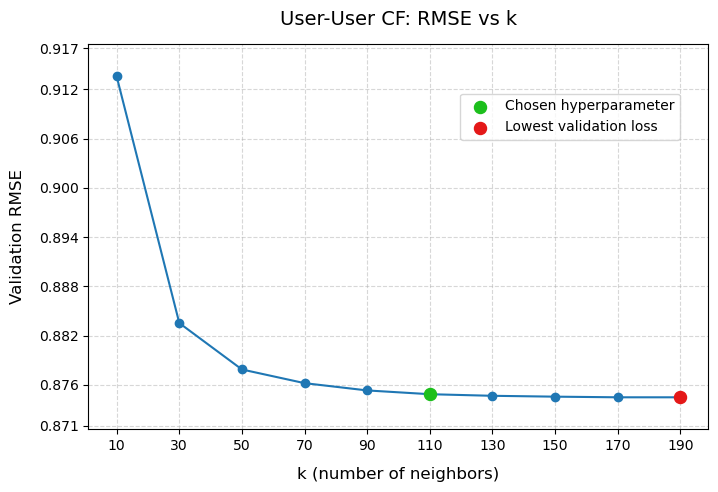

In [45]:
# Plot RMSE curve for User-User CF
plt.figure(figsize=(8,5))
plt.plot(list(rmse_dict.keys()), list(rmse_dict.values()), marker='o', color='#1f77b4')

# Highlight chosen k
chosen_k = 110
plt.scatter(chosen_k, rmse_dict[chosen_k], color="#1cbf1c", marker='o', s=75, zorder=5, label='Chosen hyperparameter')

# Highlight absolute minimum k
min_k = min(rmse_dict, key=rmse_dict.get)
plt.scatter(min_k, rmse_dict[min_k], color="#e41818", marker='o', s=75, zorder=5, label='Lowest validation loss')

# Labels, title, and formatting
plt.xlabel("k (number of neighbors)", labelpad=10, fontsize=12)
plt.ylabel("Validation RMSE", labelpad=10, fontsize=12)
plt.title("User-User CF: RMSE vs k", fontsize=14, pad=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(k_values)

# Add vertical buffer
y_min, y_max = min(rmse_dict.values()), max(rmse_dict.values())
y_buffer = (y_max - y_min) * 0.1
plt.ylim(y_min - y_buffer, y_max + y_buffer)

# Make y-axis ticks denser and rounded to 3 decimals
y_ticks = np.round(np.linspace(y_min - y_buffer, y_max + y_buffer, 9), 3)
plt.yticks(y_ticks)

# Legend and placement
plt.legend(frameon=True, bbox_to_anchor=(0.965, 0.89), fontsize=10)

# Save and show
plt.savefig("../notebooks/images/user_user_rmse_vs_k.png", dpi=300, bbox_inches='tight')
plt.show()

<u>Comment:</u>

Applying the principle of parsimony and observing the diminishing returns in validation loss, we select k = 110 as the optimal hyperparameter using the elbow method. Although k = 190 achieves the lowest validation RMSE, the improvement over 110 is minimal, and choosing the larger value increases the risk of overfitting to the validation set. Considering the negligible gain in performance alongside the higher computational cost, the lower k represents a more robust and efficient choice.

### <u> 1.3 Model Evaluation </u>

In [46]:
# Optimal k
best_k = 110

# Start time
start = time.perf_counter()

# Train final model with the best hyperparameters
model = KNNWithMeans(k=best_k, sim_options={"name":"pearson", "user_based":True})
model.fit(trainset)

# Evaluate on full test set
pred_test = model.test(testset)
rmse_total = accuracy.rmse(pred_test, verbose=False)

# Evaluate on warm test set
pred_warm = model.test(warm_testset)
rmse_warm = accuracy.rmse(pred_warm, verbose=False)

# Evaluate on cold test set
pred_cold = model.test(cold_testset)
rmse_cold = accuracy.rmse(pred_cold, verbose=False)

# Training and evaluation time
elapsed_time = time.perf_counter() - start

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [48]:
# Summary of model performance
print(
    f"Model performance (user-user) on test set using k={best_k}:\n"
    f"RMSE Total: {rmse_total:.4f}\n"
    f"RMSE Warm:  {rmse_warm:.4f}\n"
    f"RMSE Cold:  {rmse_cold:.4f}\n"
    f"Elapsed time: {elapsed_time:.1f} seconds"
)


Model performance (user-user) on test set using k=110:
RMSE Total: 0.8946
RMSE Warm:  0.8876
RMSE Cold:  1.0062
Elapsed time: 248.9 seconds


## <u> 2. Item–Item Collaborative Filtering </u>

As an alternative to user–user collaborative filtering, item–item collaborative filtering focuses on relationships between items rather than users. Instead of identifying users with similar preferences, recommendations are generated by comparing items previously rated by a user with the target item. This approach is generally more stable and computationally efficient, since items tend to receive more ratings than individual users, resulting in more reliable similarity estimates.

<br>

**<u>Similarity:</u>**

Item similarity is computed using **adjusted cosine similarity**, which corrects for user rating biases by centering each rating around the corresponding user’s average. This prevents misleading similarity scores caused by users who consistently rate higher or lower than others. For two items $i$ and $j$, adjusted cosine similarity is defined as:

<br>

$$
\text{sim}(i, j)
=
\frac{\sum_{u \in U_{ij}} (R_{ui} - \bar{R}_u + \epsilon) (R_{uj} - \bar{R}_u + \epsilon)}
{\sqrt{\sum_{u \in U_{ij}} (R_{ui} - \bar{R}_u + \epsilon)^2 } \cdot 
 \sqrt{\sum_{u \in U_{ij}} (R_{uj} - \bar{R}_u + \epsilon)^2 }}
$$

<br>

Where:  
- $U_{ij}$ denotes the set of users who have rated both items $i$ and $j$  
- $R_{ui}$ is the rating given by user $u$ to item $i$  
- $R_{uj}$ is the rating given by user $u$ to item $j$  
- $\bar{R}_u$ is the average rating given by user $u$, which removes user-specific bias
- $\epsilon$ is a small smoothing term ($10^{-8}$) to ensure numerical stability by preventing division by zero when users rate items identically

<br>

**<u>Predictions:</u>**

A predicted rating $\hat{R}_{ui}$ for user $u$ on item $i$ is computed as a weighted average of the user’s deviations from the mean on items similar to $i$:

<br>

$$
\hat{R}_{ui}
=
\bar{R}_i +
\frac{\sum_{j \in N(i;u)} \text{sim}(i, j) \cdot (R_{uj} - \bar{R}_j)}
{\sum_{j \in N(i;u)} |\text{sim}(i, j)|}
$$

<br>

Where:  
- $\bar{R}_i$ is the average rating of item $i$ across all users  
- $N(i;u)$ denotes the set of the top $k$ most similar items to item $i$ that have been rated by user $u$  
- $\bar{R}_j$ is the average rating of item $j$  
- $\text{sim}(i,j)$ is the adjusted cosine similarity between items $i$ and $j$  
- $R_{uj}$ is the rating of user $u$ for item $j$  

<br>

**<u> Hyperparameter Selection</u>**


To ensure stable and accurate predictions, the neighborhood size $k$ is **treated as a hyperparameter** and evaluated on the validation set. This allows the model to find an optimal trade-off between smoothing noise from individual ratings and focusing on the most relevant items.


### <u> 2.1 Data Preparation for surprise</u>

Given that the Surprise library does not natively implement adjusted cosine similarity, a correction for each user’s average rating is applied to the ratings before computing standard cosine similarity. This approach effectively reproduces the adjusted cosine similarity while maintaining the computational efficiency provided by the Surprise package. To avoid data leakage, the user means are computed on the training set only and then applied to the validation and test sets during prediction.


In [8]:
# buffer to avoid division by zero in cosine similarity computation
epsilon = 1e-8

# Compute mean rating per user over training set
train_user_means = train_df.groupby('userId')['rating'].mean()

# Centralize train, validation, and test sets
def center_ratings(df, user_means):
    df_centered = df.copy()
    df_centered['rating'] = df_centered.apply(
        lambda row: (row['rating'] - user_means[row['userId']]) + epsilon, axis=1
    )
    return df_centered

train_df_centered = center_ratings(train_df, train_user_means)
val_df_centered   = center_ratings(val_df, train_user_means)
warm_test_df_centered = center_ratings(warm_test_df, train_user_means)
cold_test_df_centered = center_ratings(cold_test_df, train_user_means)
test_df_centered = center_ratings(test_df, train_user_means)

# Define centered rating scale
min_rating = train_df_centered['rating'].min()
max_rating = train_df_centered['rating'].max()
reader = Reader(rating_scale=(min_rating, max_rating))

# Load training set into Surprise dataset
trainset = Dataset.load_from_df(train_df_centered, reader).build_full_trainset()

# Prepare validation and test sets as lists of tuples
valset = [(row.userId, row.movieId, row.rating) for row in val_df_centered.itertuples(index=False)]
warm_testset = [(row.userId, row.movieId, row.rating) for row in warm_test_df_centered.itertuples(index=False)]
cold_testset = [(row.userId, row.movieId, row.rating) for row in cold_test_df_centered.itertuples(index=False)]
testset = [(row.userId, row.movieId, row.rating) for row in test_df_centered.itertuples(index=False)]

# Free up memory
del train_df_centered, val_df_centered, warm_test_df_centered, cold_test_df_centered, test_df_centered

### <u> 2.2 Hyperparameter tuning </u>

In [9]:
# Hyperparameter model to be evaluated
k_values = list(range(10, 261, 25))  # 10, 35, 60, 85, 110, 135, 160, 185, 210, 235, 260

# Initialize k and rmse tracker
best_k = None
best_rmse = float('inf')
rmse_dict = {}

print("Starting item-item CF hyperparameter tuning...\n")

for i, k in enumerate(k_values, 1):
    print(f"[{i}/{len(k_values)}] Testing k={k}...", end=" ", flush=True)

    model = KNNWithMeans(
        k=k,
        sim_options={"name": "cosine", "user_based": False},
        verbose=False
    )
    
    model.fit(trainset)
    pred_val = model.test(valset)
    rmse = accuracy.rmse(pred_val, verbose=False)

    rmse_dict[k] = rmse 

    print(f"RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_k = k


# Print best hyperparameter result
print('\nHyperparameter tuning for item-item collaborative filtering:')
print(f"Best k: {best_k} with validation RMSE: {best_rmse:.4f}")

Starting item-item CF hyperparameter tuning...

[1/11] Testing k=10... RMSE: 0.8886
[2/11] Testing k=35... RMSE: 0.8556
[3/11] Testing k=60... RMSE: 0.8501
[4/11] Testing k=85... RMSE: 0.8482
[5/11] Testing k=110... RMSE: 0.8471
[6/11] Testing k=135... RMSE: 0.8465
[7/11] Testing k=160... RMSE: 0.8462
[8/11] Testing k=185... RMSE: 0.8459
[9/11] Testing k=210... RMSE: 0.8456
[10/11] Testing k=235... RMSE: 0.8455
[11/11] Testing k=260... RMSE: 0.8454

Hyperparameter tuning for item-item collaborative filtering:
Best k: 260 with validation RMSE: 0.8454


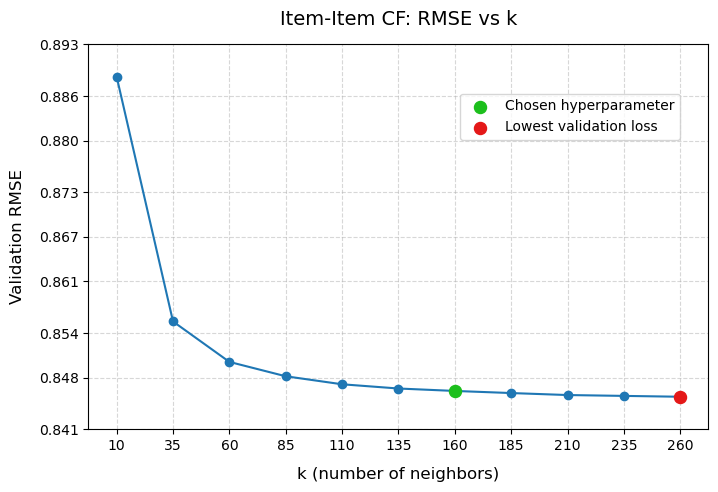

In [12]:
# Plot RMSE curve for Item-Item CF
plt.figure(figsize=(8,5))
plt.plot(list(rmse_dict.keys()), list(rmse_dict.values()), marker='o', color='#1f77b4')

# Highlight chosen k
chosen_k = 160 
plt.scatter(chosen_k, rmse_dict[chosen_k], color="#1cbf1c", marker='o', s=75, zorder=5, label='Chosen hyperparameter')

# Highlight absolute minimum k
min_k = min(rmse_dict, key=rmse_dict.get)
plt.scatter(min_k, rmse_dict[min_k], color="#e41818", marker='o', s=75, zorder=5, label='Lowest validation loss')

# Labels, title, and formatting
plt.xlabel("k (number of neighbors)", labelpad=10, fontsize=12)
plt.ylabel("Validation RMSE", labelpad=10, fontsize=12)
plt.title("Item-Item CF: RMSE vs k", fontsize=14, pad=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(k_values)

# Add vertical buffer
y_min, y_max = min(rmse_dict.values()), max(rmse_dict.values())
y_buffer = (y_max - y_min) * 0.1
plt.ylim(y_min - y_buffer, y_max + y_buffer)

# Make y-axis ticks denser and rounded to 3 decimals
y_ticks = np.round(np.linspace(y_min - y_buffer, y_max + y_buffer, 9), 3)
plt.yticks(y_ticks)

# Legend and placement
plt.legend(frameon=True, bbox_to_anchor=(0.965, 0.89), fontsize=10)

# Save and show
plt.savefig("../notebooks/images/item_item_rmse_vs_k.png", dpi=300, bbox_inches='tight')
plt.show()


<u> Comment:</u>

Following the same reasoning and the elbow method, k = 160 was selected instead of the value with the lowest validation loss.

### <u> 2.3 Model Evaluation </u>

In [13]:
# Select optimal k
best_k = 160

# Start timer
start = time.perf_counter()

# Train final model with the best hyperparameter
model = KNNWithMeans(k=best_k, sim_options={"name":"cosine", "user_based":True})
model.fit(trainset)

# Evaluate on full test set
pred_test = model.test(testset)
rmse_total = accuracy.rmse(pred_test, verbose=False)

# Evaluate on warm test set
pred_warm = model.test(warm_testset)
rmse_warm = accuracy.rmse(pred_warm, verbose=False)

# Evaluate on cold test set
pred_cold = model.test(cold_testset)
rmse_cold = accuracy.rmse(pred_cold, verbose=False)

# Training and evaluation time
elapsed_time = time.perf_counter() - start

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [14]:
print(
    f"Model performance (item-item) using k={best_k}:\n"
    f"RMSE Total: {rmse_total:.4f}\n"
    f"RMSE Warm:  {rmse_warm:.4f}\n"
    f"RMSE Cold:  {rmse_cold:.4f}\n"
    f"Elapsed time: {elapsed_time:.1f} seconds"
)

Model performance (item-item) using k=160:
RMSE Total: 0.8927
RMSE Warm:  0.8851
RMSE Cold:  1.0127
Elapsed time: 238.8 seconds


## <u> 3. Summary of findings </u>

### <u> 3.1 Model performance </u>


<table style="border-spacing:0; margin-bottom:15px;">
<tr>
<td style="text-align:center; padding:0;">
<img src="images/user_user_rmse_vs_k.png" width="450" height="338" style="display:block;"/>
</td>
<td style="width:20px;"></td> 
<td style="text-align:center; padding:0;">
<img src="images/item_item_rmse_vs_k.png" width="450" height="338" style="display:block;"/>
</td>
</tr>
</table>

<br> 
<table border="1" cellpadding="5" cellspacing="0" style="text-align: center;">
  <tr>
    <th>Model Type</th>
    <th>k (neighbors)</th>
    <th>Validation RMSE</th>
    <th colspan="3">Test RMSE</th>
    <th>Elapsed Time (s)</th>
  </tr>
  <tr>
    <th></th>
    <th></th>
    <th>Total</th>
    <th>Total</th>
    <th>Warm</th>
    <th>Cold</th>
    <th></th>
  </tr>
  <tr>
    <td>User-User CF</td>
    <td>110</td>
    <td>0.8748</td>
    <td>0.8946</td>
    <td>0.8876</td>
    <td>1.0062</td>
    <td>248.9</td>
  </tr>
  <tr>
    <td>Item-Item CF</td>
    <td>160</td>
    <td>0.8462</td>
    <td>0.8927</td>
    <td>0.8851</td>
    <td>1.0127</td>
    <td>238.8</td>
  </tr>
</table>

### <u> 3.2 Discussion </u>

Overall, the item-item CF achieves slightly better validation RMSE, but on the test set, user-user CF shows a small advantage, particularly on the cold test subset. Elapsed times are similar, reflecting comparable performance between the two memory-based approaches. These results reaffirm the earlier observation regarding scalability limitations: both methods require constructing large similarity matrices, making them computationally demanding and sensitive to sparse data. Cold-start users or items remain challenging, and prediction reliability decreases for underrepresented cases. While memory-based CF produces reasonable recommendations, its applicability is constrained for larger or sparser datasets, highlighting the potential benefits of model-based or hybrid approaches in such scenarios.